In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('meta_tumor_data.csv', index_col=0)

---
### preprocessing
- remove rows which MGMT status are indeterminate or nan
- remove rows which 1p/19q are nan

In [3]:
df = data[data['MGMT status_indeterminate'] == 0]
df = df[df['MGMT status_nan'] == 0]
df = df[df['1p/19q_nan'] == 1]

df.head(3)

,ID,Grade,Age at MRI,MGMT index,1-dead 0-alive,OS,Sex_F,grade_2,grade_3,grade_4,...,tumor_2,tumor_4,brain,right_percentage,front_percentage,up_percentage,tumor_1_percent,tumor_2_percent,tumor_4_percent,tumor_size
0,UCSF-PDGM-004,4,66,0.0,1,1303.0,0,0,0,1,...,18654,15672,1432027,0.000000,0.000000,0.521935,0.005302,0.013026,0.010944,0.029272
3,UCSF-PDGM-008,4,70,0.0,1,185.0,0,0,0,1,...,83082,42573,1390174,0.999176,0.182699,0.667969,0.030900,0.059764,0.030624,0.121288
4,UCSF-PDGM-009,4,68,0.0,1,389.0,1,0,0,1,...,98689,15417,1393310,0.001574,0.852107,0.880543,0.003817,0.070831,0.011065,0.085712


In [4]:
age = np.array(df['Age at MRI']).reshape(-1,1)
scaler = StandardScaler()
standardized_age = scaler.fit_transform(age)
df['age'] = standardized_age
df.head(3)

,ID,Grade,Age at MRI,MGMT index,1-dead 0-alive,OS,Sex_F,grade_2,grade_3,grade_4,...,tumor_4,brain,right_percentage,front_percentage,up_percentage,tumor_1_percent,tumor_2_percent,tumor_4_percent,tumor_size,age
0,UCSF-PDGM-004,4,66,0.0,1,1303.0,0,0,0,1,...,15672,1432027,0.000000,0.000000,0.521935,0.005302,0.013026,0.010944,0.029272,0.417058
3,UCSF-PDGM-008,4,70,0.0,1,185.0,0,0,0,1,...,42573,1390174,0.999176,0.182699,0.667969,0.030900,0.059764,0.030624,0.121288,0.753049
4,UCSF-PDGM-009,4,68,0.0,1,389.0,1,0,0,1,...,15417,1393310,0.001574,0.852107,0.880543,0.003817,0.070831,0.011065,0.085712,0.585053


In [5]:
df.columns

Index(['ID', 'Grade', 'Age at MRI', 'MGMT index', '1-dead 0-alive', 'OS',
       'Sex_F', 'grade_2', 'grade_3', 'grade_4',
       'pathologic diagnosis_Astrocytoma', 'pathologic diagnosis_Glioblastoma',
       'pathologic diagnosis_Oligodendroglioma', 'MGMT status_indeterminate',
       'MGMT status_negative', 'MGMT status_positive', 'MGMT status_nan',
       '1p/19q_co-deletion', '1p/19q_intact', '1p/19q_relative co-deletion',
       '1p/19q_nan', 'IDH_IDH1 p.Arg132His', 'IDH_IDH1 p.R132C',
       'IDH_IDH1 p.R132G', 'IDH_IDH1 p.R132H', 'IDH_IDH1 p.R132S',
       'IDH_IDH2 p.Arg172Trp', 'IDH_IDH2 p.R172K', 'IDH_mutated (NOS)',
       'IDH_wildtype', 'id', 'tumor_1', 'tumor_2', 'tumor_4', 'brain',
       'right_percentage', 'front_percentage', 'up_percentage',
       'tumor_1_percent', 'tumor_2_percent', 'tumor_4_percent', 'tumor_size',
       'age'],
      dtype='object')

In [6]:
X = df[['age', 'Sex_F', 'grade_3', 'grade_4',
       'pathologic diagnosis_Astrocytoma', 'pathologic diagnosis_Glioblastoma',
       '1p/19q_co-deletion', '1p/19q_relative co-deletion', 'IDH_IDH1 p.Arg132His', 
       'IDH_IDH1 p.R132C','IDH_IDH1 p.R132G', 'IDH_IDH1 p.R132H', 'IDH_IDH1 p.R132S',
       'IDH_IDH2 p.Arg172Trp', 'IDH_IDH2 p.R172K', 'IDH_mutated (NOS)']]
y = df['MGMT status_positive']

# reference level: male, grade_2, 'pathologic diagnosis_Oligodendroglioma', IDH_wildtype, '1p/19q_intact'

In [7]:
from collections import Counter
Counter(y)

Counter({0: 24, 1: 62})

#### SMOTE for oversampling

In [8]:
oversample = SMOTE(random_state=0)
X, y = oversample.fit_resample(X,y)

In [9]:
Counter(y)

Counter({0: 62, 1: 62})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=569)

---
#### Logistic

In [11]:
log = LogisticRegression(random_state=0)
log.fit(X_train, y_train)
print('Training score:',log.score(X_train, y_train))
print('Testing score:', log.score(X_test, y_test))

Training score: 0.5959595959595959
Testing score: 0.8


---
#### KNN

In [12]:
neighbors = range(2,20,1)
avg_score = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)
neighbors[max_index]

2

In [13]:
knn = KNeighborsClassifier(n_neighbors=neighbors[max_index])
knn.fit(X_train, y_train)
print('Training score:',knn.score(X_train, y_train))
print('Testing score:', knn.score(X_test, y_test))

Training score: 0.8888888888888888
Testing score: 0.64


---
#### Decision Tree

In [14]:
depth = range(1,21)
avg_score = []
for d in depth:
    tree = DecisionTreeClassifier(max_depth = d, random_state=0)
    score = cross_val_score(tree, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)
depth[max_index]

9

In [15]:
tree = DecisionTreeClassifier(max_depth=depth[max_index], random_state=0)
tree.fit(X_train, y_train)
print('Training score:',tree.score(X_train, y_train))
print('Testing score:', tree.score(X_test, y_test))

Training score: 0.8585858585858586
Testing score: 0.48


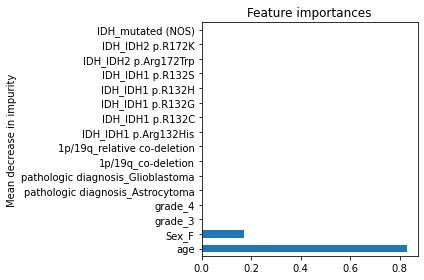

In [16]:
tree_importance = tree.feature_importances_
tree_importances = pd.Series(tree_importance, index=X.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
tree_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---
#### Random Forest

In [17]:
estimators = range(10,200,10)
avg_score = []
for n in estimators:
    rf = RandomForestClassifier(n_estimators = n, random_state=0)
    score = cross_val_score(rf, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)

In [18]:
estimators[max_index]

40

In [19]:
rf = RandomForestClassifier(n_estimators=estimators[max_index], random_state=0)
rf.fit(X_train, y_train)
print('Training score:',rf.score(X_train, y_train))
print('Testing score:', rf.score(X_test, y_test))

Training score: 0.9393939393939394
Testing score: 0.48


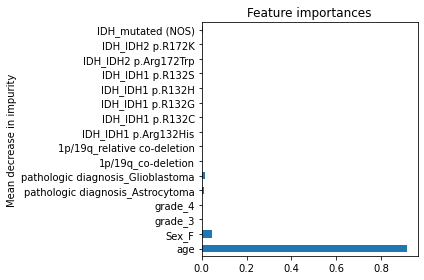

In [20]:
forest_importance = rf.feature_importances_
forest_importances = pd.Series(forest_importance, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---
#### Adaboost

In [21]:
estimators = range(10,100,10)
avg_score = []
for n in estimators:
    ada = AdaBoostClassifier(n_estimators = n, random_state=0)
    score = cross_val_score(ada, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)

In [22]:
ada = AdaBoostClassifier(n_estimators=estimators[max_index], random_state=0)
ada.fit(X_train, y_train)
print('Training score:',ada.score(X_train, y_train))
print('Testing score:', ada.score(X_test, y_test))

Training score: 0.8383838383838383
Testing score: 0.48


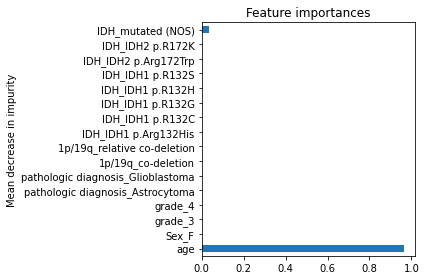

In [23]:
ada_importance = ada.feature_importances_
ada_importances = pd.Series(ada_importance, index=X.columns)

fig, ax = plt.subplots()
ada_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---
## with tumor size and location data

In [24]:
tumor_df = df[['right_percentage', 'front_percentage', 'up_percentage',
       'tumor_1_percent', 'tumor_2_percent', 'tumor_4_percent', 'tumor_size']]
scaler = StandardScaler()
standardized_tumor = scaler.fit_transform(tumor_df)

In [25]:
df['standardized_right_percentage'] = standardized_tumor[:,0]
df['standardized_front_percentage'] = standardized_tumor[:,1]
df['standardized_up_percentage'] = standardized_tumor[:,2]
df['standardized_1_percentage'] = standardized_tumor[:,3]
df['standardized_2_percentage'] = standardized_tumor[:,4]
df['standardized_4_percentage'] = standardized_tumor[:,5]
df['standardized_tumor_percentage'] = standardized_tumor[:,6]

In [26]:
X = df[['age', 'Sex_F', 'grade_3', 'grade_4',
       'pathologic diagnosis_Astrocytoma', 'pathologic diagnosis_Glioblastoma',
       '1p/19q_co-deletion', '1p/19q_relative co-deletion', 'IDH_IDH1 p.Arg132His', 
       'IDH_IDH1 p.R132C','IDH_IDH1 p.R132G', 'IDH_IDH1 p.R132H', 'IDH_IDH1 p.R132S',
       'IDH_IDH2 p.Arg172Trp', 'IDH_IDH2 p.R172K', 'IDH_mutated (NOS)',
       'standardized_right_percentage', 'standardized_front_percentage','standardized_up_percentage', 
       'standardized_1_percentage', 'standardized_2_percentage', 'standardized_4_percentage', 'standardized_tumor_percentage']]
y = df['MGMT status_positive']


# reference level: male, grade_2, 'pathologic diagnosis_Oligodendroglioma', IDH_wildtype, '1p/19q_intact'

---
#### SMOTE for oversampling

In [27]:
oversample = SMOTE(random_state=0)
X, y = oversample.fit_resample(X,y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=569)

---
#### logistic

In [29]:
log = LogisticRegression(random_state=0)
log.fit(X_train, y_train)
print('Training score:',log.score(X_train, y_train))
print('Testing score:', log.score(X_test, y_test))

Training score: 0.6868686868686869
Testing score: 0.84


---
#### KNN

In [30]:
neighbors = range(2,20,1)
avg_score = []
for n in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n)
    score = cross_val_score(knn, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)
neighbors[max_index]

3

In [31]:
knn = KNeighborsClassifier(n_neighbors=neighbors[max_index])
knn.fit(X_train, y_train)
print('Training score:',knn.score(X_train, y_train))
print('Testing score:', knn.score(X_test, y_test))

Training score: 0.8686868686868687
Testing score: 0.76


---
#### Decision Tree

In [32]:
depth = range(1,21)
avg_score = []
for d in depth:
    tree = DecisionTreeClassifier(max_depth = d, random_state=0)
    score = cross_val_score(tree, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)
depth[max_index]

8

In [33]:
tree = DecisionTreeClassifier(max_depth=depth[max_index], random_state=0)
tree.fit(X_train, y_train)
print('Training score:',tree.score(X_train, y_train))
print('Testing score:', tree.score(X_test, y_test))

Training score: 0.9191919191919192
Testing score: 0.52


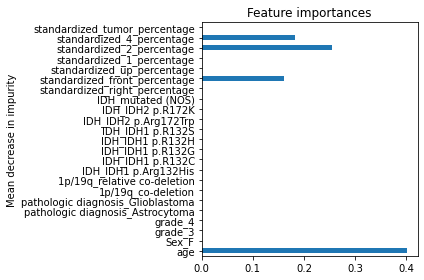

In [34]:
tree_importance = tree.feature_importances_
tree_importances = pd.Series(tree_importance, index=X.columns)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
tree_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

with or without tumor data

---
#### Random Forest

In [35]:
estimators = range(10,100,10)
avg_score = []
for n in estimators:
    rf = RandomForestClassifier(n_estimators = n, random_state=0)
    score = cross_val_score(rf, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)

In [36]:
estimators[max_index]

50

In [37]:
rf = RandomForestClassifier(n_estimators=estimators[max_index], random_state=0)
rf.fit(X_train, y_train)
print('Training score:',rf.score(X_train, y_train))
print('Testing score:', rf.score(X_test, y_test))

Training score: 1.0
Testing score: 0.8


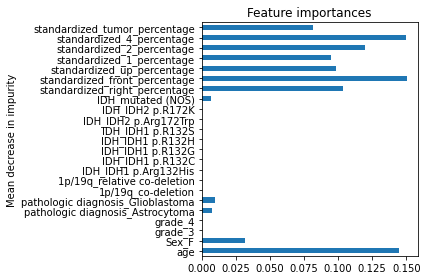

In [38]:
forest_importance = rf.feature_importances_
forest_importances = pd.Series(forest_importance, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

---
#### Adaboost

In [39]:
estimators = range(10,100,10)
avg_score = []
for n in estimators:
    ada = AdaBoostClassifier(n_estimators = n, random_state=0)
    score = cross_val_score(ada, X_train, y_train, cv=5)
    avg_score.append(score.mean())

max_index = np.argmax(avg_score)

In [40]:
ada = AdaBoostClassifier(n_estimators=estimators[max_index], random_state=0)
ada.fit(X_train, y_train)
print('Training score:',ada.score(X_train, y_train))
print('Testing score:', ada.score(X_test, y_test))

Training score: 1.0
Testing score: 0.52


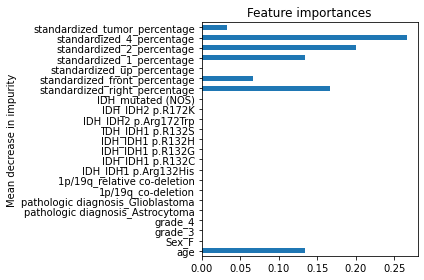

In [41]:
ada_importance = ada.feature_importances_
ada_importances = pd.Series(ada_importance, index=X.columns)

fig, ax = plt.subplots()
ada_importances.plot.barh(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()